In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from torch import nn # nn contains all of PyTorch's building blocks of neural networks
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, PredefinedSplit
from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef, balanced_accuracy_score, make_scorer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import shap

/home/user/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def torch_accuracy_function(y_true, y_pred):
    y_true = y_true.numpy()
    y_pred = y_pred.detach().numpy()

    return accuracy_score(y_true, y_pred)

In [3]:
def categorize(dataframe):
    a_values = dataframe['unitcell_a'].values
    b_values = dataframe['unitcell_b'].values
    alpha_values = dataframe['unitcell_alpha'].values
    beta_values = dataframe['unitcell_beta'].values
    gamma_values = dataframe['unitcell_gamma'].values
    categories = []
    for i in range(len(a_values)):
        a_equals_b = round(a_values[i], 2) == round(b_values[i], 2)
        gamma_equals_90 = 80 <= gamma_values[i] <= 100
        gamma_equals_60 = 50 <= gamma_values[i] <= 70
        gamma_equals_120 = 110 <= gamma_values[i] <= 130
        
        if a_equals_b:
            if gamma_equals_90:
                categories.append('Square')
            elif gamma_equals_60 or gamma_equals_120:
                categories.append('Hexagonal')
            else:
                categories.append('Uncategorized')
                
        else:
            if gamma_equals_90:
                categories.append('Rectangular')
            else:
                categories.append('Uncategorized')
                
    return categories

In [4]:
df = pd.read_csv("data_8.csv")
external_df = pd.read_csv("external_test.csv")

In [5]:
len(df)

236

In [6]:
df

,system,number_density,atom_types,unitcell_alpha,unitcell_beta,unitcell_gamma,unitcell_a,unitcell_b,unitcell_c,density,...,layer_width,z_variance,spin_orbit_coupling,oxidation,entropy,linear_centre_fraction,alpha_max,alpha_max_temperature,alpha_300,saruration
0,MoSe2,0.0315,2,90,90,60,3.3174,3.3174,10.0,2.6651,...,3.332609e+00,1.8510,3111696,6,5.291979,0.0,-0.129205,10,19.879219,20
1,blue-P,0.0217,1,90,90,120,3.2621,3.2621,10.0,0.6728,...,1.236789e+00,0.3824,50625,0,0.000000,0.0,-10.253350,60,8.648487,180
2,c63,0.0347,1,90,90,60,6.3156,6.3156,10.0,0.4169,...,0.000000e+00,0.0000,1296,0,0.000000,0.0,-7.452979,220,-6.978796,1000
3,twin-graphene,0.0551,1,90,90,120,6.1417,6.1417,10.0,0.6612,...,2.357546e+00,0.9263,1296,0,0.000000,0.0,-1.700107,790,8.271276,10
4,alpha-α-C2As2,0.0482,2,90,90,60,3.0968,3.0968,10.0,2.0951,...,3.461099e+00,1.7897,1185921,0,5.762826,0.0,-0.582627,30,11.851636,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,beta-β-Sn2P2,0.0305,2,90,90,60,3.8932,3.8932,10.0,2.2855,...,5.202448e+00,4.3902,6250000,3,5.762826,0.0,-7.420966,50,8.184467,140
232,6.6.6-GY,0.0292,1,90,90,90,6.8844,11.9243,10.0,0.3508,...,0.000000e+00,0.0000,1296,0,0.000000,0.0,-10.809670,210,-9.881993,1000
233,AlGD-HEX,0.0093,2,90,90,60,13.1815,13.1814,10.0,0.1316,...,8.107819e-07,0.0000,28561,3,3.409707,0.0,-15.337266,50,-1.256259,940
234,3,0.0361,1,90,90,120,10.7360,10.7360,10.0,0.4328,...,0.000000e+00,0.0000,1296,0,0.000000,0.0,0.000000,0,20.679880,10


In [7]:
# Dropping Duplicate Data

systems_to_drop = ['CEY', 'GY1']
df = df[~df['system'].isin(systems_to_drop)]

In [8]:
df['class'] = df['alpha_max'].apply(lambda x: 0 if x >= 0 else 1)
external_df['class'] = external_df['alpha_max'].apply(lambda x: 0 if x >= 0 else 1)

/tmp/ipykernel_167288/1451956330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['class'] = df['alpha_max'].apply(lambda x: 0 if x >= 0 else 1)


In [9]:
df["basis"] = categorize(df)
external_df['basis'] = categorize(external_df)

/tmp/ipykernel_167288/2315501592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["basis"] = categorize(df)


In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
columns_to_encode = ["basis"]

# OneHotEncoder instance
encoder = OneHotEncoder(sparse_output=False, drop=None)

# Fit and transform the columns to be encoded
encoded_data = encoder.fit_transform(df[columns_to_encode])
external_encoded_data = encoder.transform(external_df[columns_to_encode])

# Get the new column names
encoded_column_names = encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame for the encoded columns
encoded_df = pd.DataFrame(encoded_data, columns=encoded_column_names)
external_encoded_df = pd.DataFrame(external_encoded_data, columns=encoded_column_names)

In [12]:
len(encoded_df), len(df)

(234, 234)

In [13]:
# Concatenate the encoded columns back with the original DataFrame
df = pd.concat([df.drop(columns=columns_to_encode), encoded_df], axis=1)
external_df = pd.concat([external_df.drop(columns=columns_to_encode), external_encoded_df], axis=1)

# Display the encoded DataFrame
df

,system,number_density,atom_types,unitcell_alpha,unitcell_beta,unitcell_gamma,unitcell_a,unitcell_b,unitcell_c,density,...,linear_centre_fraction,alpha_max,alpha_max_temperature,alpha_300,saruration,class,basis_Hexagonal,basis_Rectangular,basis_Square,basis_Uncategorized
0,MoSe2,0.0315,2,90,90,60,3.3174,3.3174,10.0,2.6651,...,0.0,-0.129205,10,19.879219,20,1,1.0,0.0,0.0,0.0
1,blue-P,0.0217,1,90,90,120,3.2621,3.2621,10.0,0.6728,...,0.0,-10.253350,60,8.648487,180,1,1.0,0.0,0.0,0.0
2,c63,0.0347,1,90,90,60,6.3156,6.3156,10.0,0.4169,...,0.0,-7.452979,220,-6.978796,1000,1,1.0,0.0,0.0,0.0
3,twin-graphene,0.0551,1,90,90,120,6.1417,6.1417,10.0,0.6612,...,0.0,-1.700107,790,8.271276,10,1,1.0,0.0,0.0,0.0
4,alpha-α-C2As2,0.0482,2,90,90,60,3.0968,3.0968,10.0,2.0951,...,0.0,-0.582627,30,11.851636,50,1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,beta-β-Sn2P2,0.0305,2,90,90,60,3.8932,3.8932,10.0,2.2855,...,0.0,-7.420966,50,8.184467,140,1,1.0,0.0,0.0,0.0
230,6.6.6-GY,0.0292,1,90,90,90,6.8844,11.9243,10.0,0.3508,...,0.0,-10.809670,210,-9.881993,1000,1,0.0,1.0,0.0,0.0
231,AlGD-HEX,0.0093,2,90,90,60,13.1815,13.1814,10.0,0.1316,...,0.0,-15.337266,50,-1.256259,940,1,1.0,0.0,0.0,0.0
232,3,0.0361,1,90,90,120,10.7360,10.7360,10.0,0.4328,...,0.0,0.000000,0,20.679880,10,0,1.0,0.0,0.0,0.0


In [14]:
df["types_of_bond_angle_per_bond"] = df["types_of_bond_angle"].values / df["bond_types"].values
external_df["types_of_bond_angle_per_bond"] = external_df["types_of_bond_angle"].values / external_df["bond_types"].values

In [15]:
len(df)

234

In [16]:
df.drop(columns=[
                  # 'system', 
                  'number_density',
                  # 'atom_types',
                  'unitcell_alpha','unitcell_beta', 'unitcell_gamma', 'unitcell_a', 'unitcell_b','unitcell_c', 
                  'density',
                  'mean_coordination',
                  # 'packing_fraction',
                  # 'reduced_mass',
                  # 'average_mass', 
                  'largest_pore_radius', 
                  'bond_types', 
                  'mean_bond_length',
                  # 'bond_variance', 
                  # 'bond_std',
                  'bond_strain',
                  'electronegativity', 
                  # 'effective_electronegativity',
                  # 'types_of_bond_angle',
                  'symmetry_number', 
                  'pointgroup',
                  'mean_bond_angle', 
                  'angle_variance',
                  # 'std_angle', 
                  'types_puckering',
                  'max_puckering',
                  'mean_puckering',
                  'bond_density', 
                  'energy',
                  'num_layers', 
                  # 'layer_width', 
                  'z_variance', 
                  'oxidation', 
                  'entropy',
                  'alpha_max', 'alpha_max_temperature', 'alpha_300', 'saruration',
                  # 'class',
                  # 'basis_Hexagonal', 
                  # 'basis_Rectangular', 
                  # 'basis_Square',
                  'basis_Uncategorized',
                  'linear_centre_fraction',
                  'spin_orbit_coupling',
                  # 'types_of_bond_angle_per_bond'
                ], inplace=True)

In [17]:
external_df.drop(columns=[
                  # 'system', 
                  'number_density',
                  # 'atom_types',
                  'unitcell_alpha','unitcell_beta', 'unitcell_gamma', 'unitcell_a', 'unitcell_b','unitcell_c', 
                  'density',
                  'mean_coordination',
                  # 'packing_fraction',
                  # 'reduced_mass',
                  # 'average_mass', 
                  'largest_pore_radius', 
                  'bond_types', 
                  'mean_bond_length',
                  # 'bond_variance', 
                  # 'bond_std',
                  'bond_strain',
                  'electronegativity', 
                  # 'effective_electronegativity',
                  # 'types_of_bond_angle',
                  'symmetry_number', 
                  'pointgroup',
                  'mean_bond_angle', 
                  'angle_variance',
                  # 'std_angle', 
                  'types_puckering',
                  'max_puckering',
                  'mean_puckering',
                  'bond_density', 
                  'energy',
                  'num_layers', 
                  # 'layer_width', 
                  'z_variance', 
                  'oxidation', 
                  'entropy',
                  'alpha_max', 'alpha_max_temperature', 'alpha_300', 'saruration',
                  # 'class',
                  # 'basis_Hexagonal', 
                  # 'basis_Rectangular', 
                  # 'basis_Square',
                  'basis_Uncategorized',
                  'linear_centre_fraction',
                  'spin_orbit_coupling',
                  'predicted_nte_max'
                  # 'types_of_bond_angle_per_bond'
                ], inplace=True)

In [18]:
df.columns

Index(['system', 'atom_types', 'packing_fraction', 'reduced_mass',
       'average_mass', 'bond_variance', 'bond_std',
       'effective_electronegativity', 'types_of_bond_angle', 'std_angle',
       'layer_width', 'class', 'basis_Hexagonal', 'basis_Rectangular',
       'basis_Square', 'types_of_bond_angle_per_bond'],
      dtype='object')

In [19]:
external_df.columns

Index(['system', 'atom_types', 'packing_fraction', 'reduced_mass',
       'average_mass', 'bond_variance', 'bond_std',
       'effective_electronegativity', 'types_of_bond_angle', 'std_angle',
       'layer_width', 'class', 'basis_Hexagonal', 'basis_Rectangular',
       'basis_Square', 'types_of_bond_angle_per_bond'],
      dtype='object')

In [20]:
y = df['class'].values

In [21]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=5, stratify=y)

In [22]:
train_labels = train_df['system'].values
test_labels = test_df['system'].values
external_labels = test_df['system'].values

In [23]:
feature_names = df.columns

In [24]:
X = df.drop(columns=[ 'system', 'class']).values
y = df['class'].values

In [25]:
X_external = external_df.drop(columns=[ 'system', 'class']).values
y_external = external_df['class'].values

In [26]:
len(y)

234

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5, stratify=y)

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_external = scaler.transform(X_external)

In [29]:
X_train.shape

(187, 14)

In [30]:
model = SVC(kernel='rbf', random_state=42, class_weight={0:3.2, 1:1}, gamma='auto', C=0.5, probability=True)

In [31]:
model.fit(X_train, y_train)

SVC(C=0.5, class_weight={0: 3.2, 1: 1}, gamma='auto', probability=True,
    random_state=42)

In [32]:
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_external_pred = model.predict(X_external)

In [33]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.66      0.74      0.69        34
           1       0.94      0.92      0.93       153

    accuracy                           0.88       187
   macro avg       0.80      0.83      0.81       187
weighted avg       0.89      0.88      0.88       187



In [34]:
print(round(matthews_corrcoef(y_train, y_train_pred), 2))

0.62


In [35]:
print(round(balanced_accuracy_score(y_train, y_train_pred), 2))

0.83


In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.95      0.95      0.95        39

    accuracy                           0.91        47
   macro avg       0.85      0.85      0.85        47
weighted avg       0.91      0.91      0.91        47



In [37]:
print(round(matthews_corrcoef(y_test, y_pred), 3))

0.699


In [38]:
print(round(balanced_accuracy_score(y_test, y_pred), 2))

0.85


In [39]:
print(y_external_pred)

[1 1 1 0 1 1 1 0]


In [40]:
probabilities = model.predict_proba(X_test)
print(min(probabilities[0]), max(probabilities[0]))

0.10076184526842982 0.8992381547315701


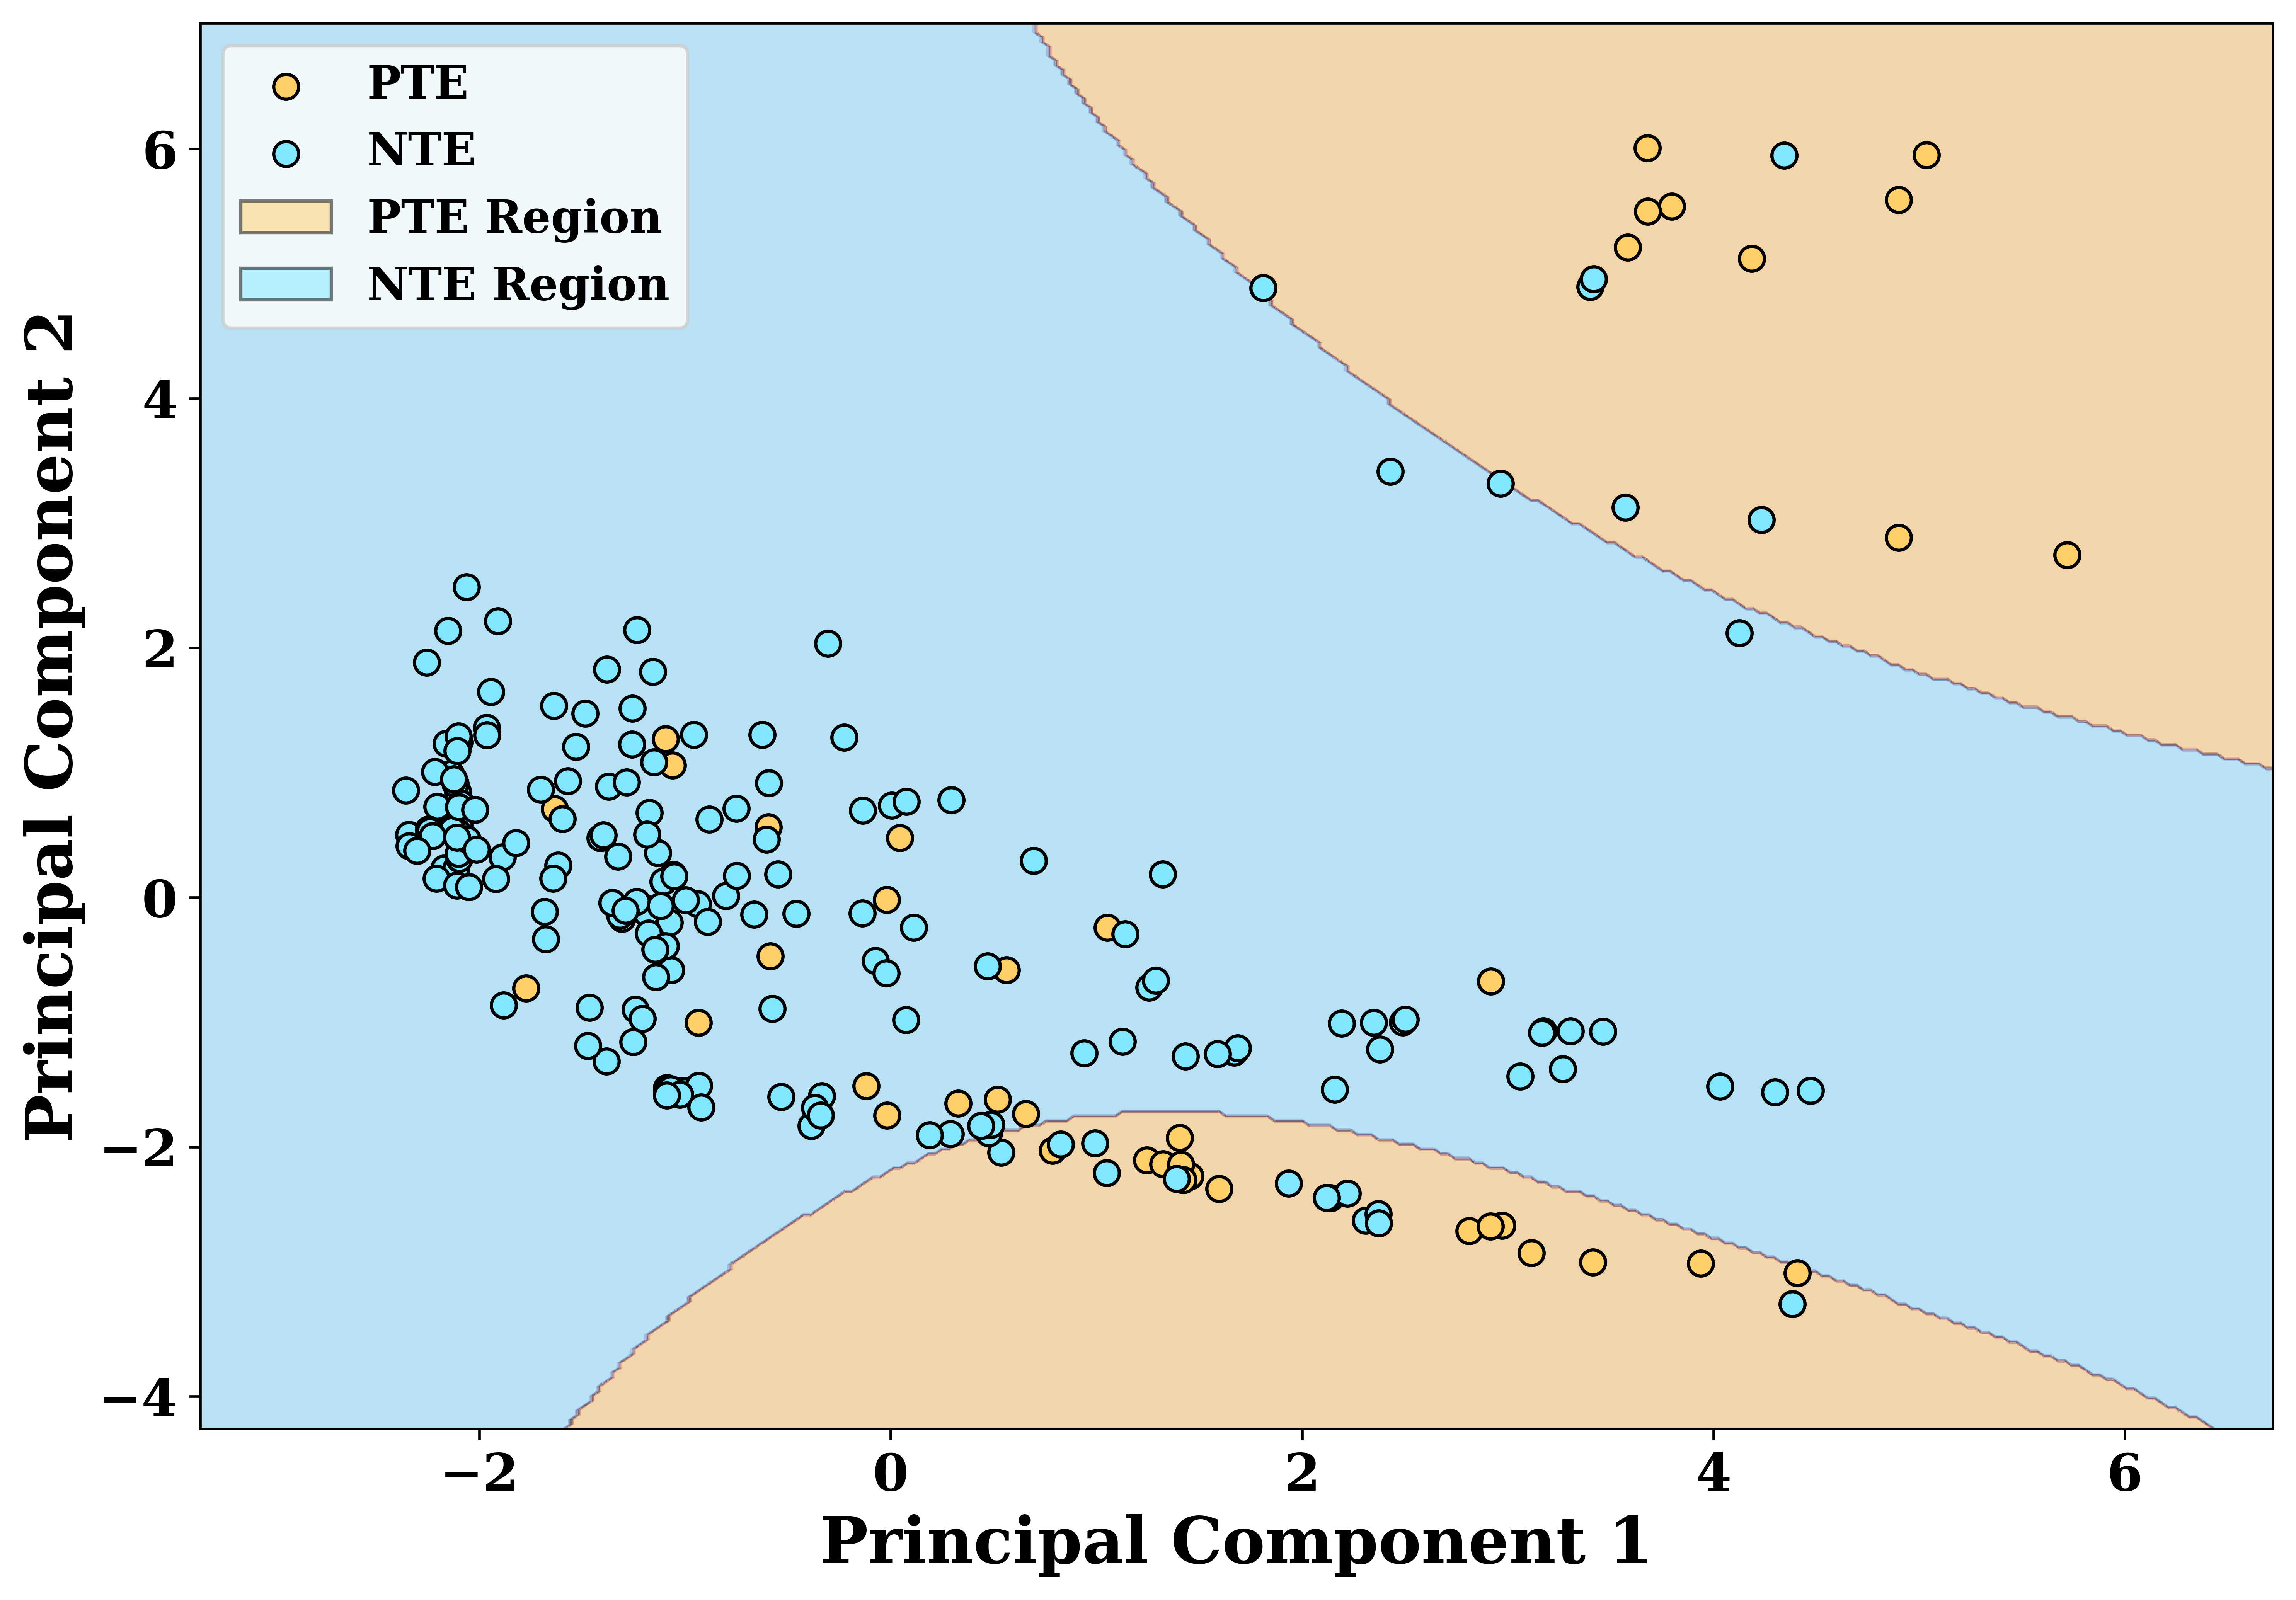

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.patches import Patch

# ---------------------------------------------------
# 1️⃣ Combine Train and Test
X_all = np.vstack((X_train, X_test))
y_all = np.hstack((y_train, y_test))
unique_classes = np.unique(y_all)

# 2️⃣ Get Model Predictions
# y_pred_all = model.predict(X_all)

# # 3️⃣ Apply Scaler
# X_all_scaled = scaler.transform(X_all)

# 4️⃣ Perform PCA (2 components for plotting)
pca = PCA(n_components=2)
X_all_pca = pca.fit_transform(X_all)

# ---------------------------------------------------
# 5️⃣ Create a meshgrid in the PCA space
x_min, x_max = X_all_pca[:, 0].min() - 1, X_all_pca[:, 0].max() + 1
y_min, y_max = X_all_pca[:, 1].min() - 1, X_all_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# 6️⃣ Inverse transform the mesh points back to the original feature space
mesh_pca = np.c_[xx.ravel(), yy.ravel()]
mesh_orig_space = pca.inverse_transform(mesh_pca)

# 7️⃣ Get Model Predictions for the mesh points
zz = model.predict(mesh_orig_space)
zz = zz.reshape(xx.shape)

# ---------------------------------------------------
# 8️⃣ Plot the Decision Boundary
cmap = plt.cm.managua
fig, ax = plt.subplots(figsize=(10, 7), dpi=600)
plt.contourf(xx, yy, zz, alpha=0.5, cmap=cmap)
# plt.scatter(X_all_pca[:, 0], X_all_pca[:, 1], c=y_all, edgecolors="k", cmap='coolwarm', s=60)
scatter_cmap = cmap
class_colors = {
    0: scatter_cmap(0.0),  # Blue end
    1: scatter_cmap(1.0)   # Red end
}
class_label = ["PTE", "NTE"]

for class_value in unique_classes:
    mask = y_all == class_value
    ax.scatter(
        X_all_pca[mask, 0],
        X_all_pca[mask, 1],
        label=f'{class_label[class_value]}',
        color=class_colors[class_value],
        s=60,
        edgecolors="k"
    )

contour_patches = [
    Patch(facecolor=cmap(0.0), edgecolor='k', alpha=0.5, label=f'{class_label[0]} Region'),
    Patch(facecolor=cmap(1.0), edgecolor='k', alpha=0.5, label=f'{class_label[1]} Region')
]

# Get scatter legend handles
scatter_handles, scatter_labels = ax.get_legend_handles_labels()

# Combine
all_handles = scatter_handles + contour_patches
all_labels = scatter_labels + [patch.get_label() for patch in contour_patches]

# Modify feature names (y-axis labels)
for text in ax.get_yticklabels():
    text.set_fontsize(16)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

for text in ax.get_xticklabels():
    text.set_fontsize(16)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

# Modify axis labels and title
ax.set_xlabel(ax.get_xlabel(), fontsize=20, fontweight='bold', fontfamily='serif')
ax.set_ylabel(ax.get_ylabel(), fontsize=20, fontweight='bold', fontfamily='serif')
ax.set_title(ax.get_title(), fontsize=20, fontweight='bold')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
legend = ax.legend(all_handles, all_labels, fontsize=14, title_fontsize=16)
for text in legend.get_texts():
    text.set_fontfamily('serif')     # or 'Times New Roman', etc.
    text.set_fontweight('bold')
    text.set_fontstyle('normal')  
plt.tight_layout()
plt.savefig("decision_boundary.svg")
plt.show()

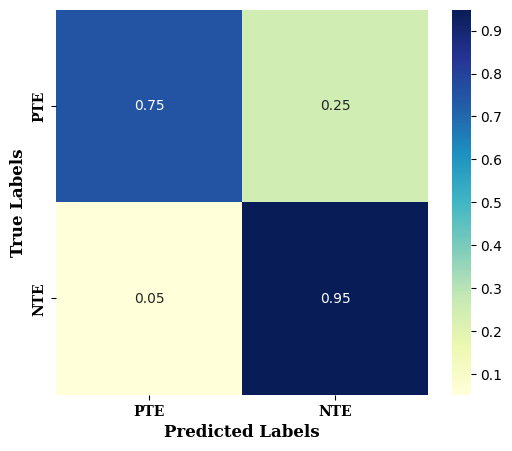

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, normalize='true')  # Normalize rows
    fig, ax = plt.subplots(figsize=(6, 5))
    
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel('Predicted Labels', fontweight='bold', fontfamily='serif', fontsize=12)
    plt.ylabel('True Labels', fontweight='bold', fontfamily='serif', fontsize=12)

    for text in ax.get_xticklabels():
        text.set_fontweight('bold')
        text.set_fontfamily('serif')

    for text in ax.get_yticklabels():
        text.set_fontweight('bold')
        text.set_fontfamily('serif')
        
    plt.savefig("confusion_matrix.svg")
    plt.show()

class_names = ['PTE', 'NTE']

plot_confusion_matrix(y_test, y_pred, class_names)

In [43]:
systems = []
true_values = []
pred_values = []

i = 0
for system in train_labels:
    systems.append(system)
    true_values.append(y_train[i])
    pred_values.append(y_train_pred[i])
    i += 1

j=0
for system in test_labels:
    systems.append(system)
    true_values.append(y_test[j])
    pred_values.append(y_pred[j])
    j += 1

classification_pred_df = pd.DataFrame({
    'system':systems,
    'true_value': true_values,
    'pred_values':pred_values,
})

In [44]:
classification_pred_df.to_csv('classification_model.csv')

In [45]:
feature_names = list(df.drop(columns=['system', 'class']).columns)
feature_names

['atom_types',
 'packing_fraction',
 'reduced_mass',
 'average_mass',
 'bond_variance',
 'bond_std',
 'effective_electronegativity',
 'types_of_bond_angle',
 'std_angle',
 'layer_width',
 'basis_Hexagonal',
 'basis_Rectangular',
 'basis_Square',
 'types_of_bond_angle_per_bond']

In [46]:
feature_names = ['A_typ', 'PF', r'$\bar{\boldsymbol{\mu}}$', r'$\bar{\mathbf{m}}$', 'B_var', 'STDB', r'$\bar{\boldsymbol{\chi}}$', 
                 'BA_typ', 'STDA', 'LW', 'Hexagonal', 'Rectangular', 'Square', 'TBA/TB']

In [47]:
explainer = shap.KernelExplainer(model=model.predict_proba, data=X_train)
shap_values = explainer.shap_values(X_test)


Using 187 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/47 [00:00<?, ?it/s]

In [48]:
shap_values.shape

(47, 14, 2)

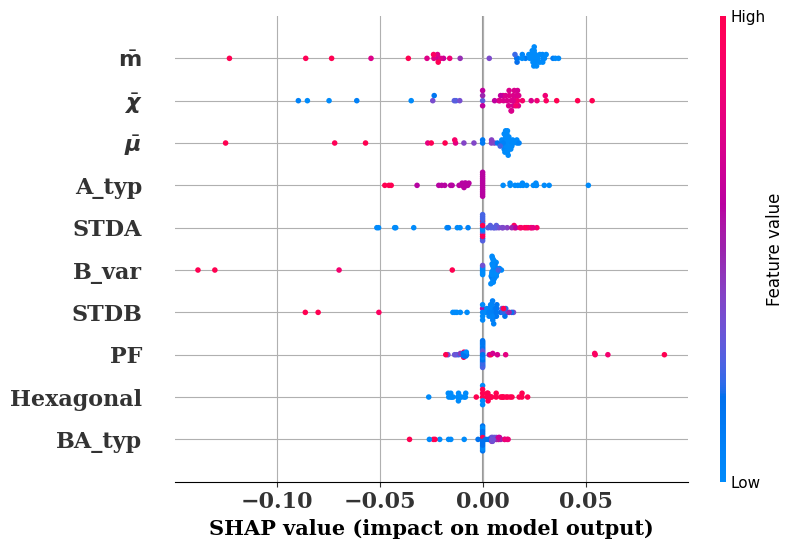

In [49]:
shap.summary_plot(shap_values[:, :, 1], X_test, max_display=10, feature_names=feature_names, show=False)
ax = plt.gca()

# Modify feature names (y-axis labels)
for text in ax.get_yticklabels():
    text.set_fontsize(16)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

for text in ax.get_xticklabels():
    text.set_fontsize(16)  # Increase font size
    text.set_fontweight('bold')  # Make text bold
    text.set_fontfamily('serif')

# Modify axis labels and title
ax.set_xlabel(ax.get_xlabel(), fontsize=15, fontweight='bold', fontfamily='serif')
ax.set_title(ax.get_title(), fontsize=20, fontweight='bold')
plt.grid()

plt.savefig("shap_summary_classification_scatter.png", dpi=600, bbox_inches="tight")  # Save as PNG
plt.savefig("shap_summary_classification_scatter.svg", dpi=600, bbox_inches="tight")